In [ ]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib

In [ ]:
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [ ]:
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive')
folder = "/content/drive/MyDrive/Lab 1 - small c-Si"
all_files_AV = glob.glob(os.path.join(folder, '*.csv'))
AV_li = {}
for filename in all_files_AV:
  #isolates name from file and drops last 3 rows
  AV_li[filename[60:].replace("Current-Voltage Data.csv", "")] = pd.read_csv(filename, sep = ',' , header = 2, nrows = 36, dtype=np.float64)
all_files_spec = glob.glob(os.path.join(folder, '*.txt'))
spec_li = {}
time = {}

for filename in all_files_spec:
  spec_li[filename.replace(" spectrum","").replace(".txt","").replace("/content/drive/MyDrive/Lab 1 - small c-Si/","")] = pd.read_csv(filename, sep = '\t' , header = 12)
  time[filename.replace(" spectrum","").replace(".txt","").replace("/content/drive/MyDrive/Lab 1 - small c-Si/","")] = float(list(pd.read_csv(filename, sep = ':' , header = 5))[1])
URL_IRR = "https://raw.githubusercontent.com/farbowitz/PHY6011/main/1sun%20spectrum.txt"
URL_CALIB = "https://raw.githubusercontent.com/farbowitz/PHY6000/main/FLMS02587_ccda_20180716_1441.IRRADCAL.csv"
AvsVdata = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6011/main/20-11-17_15-25-41%20red-2%20Current-Voltage%20Data.csv", sep = ',' , header = 2, nrows=36, dtype=np.float64)
irr_spec = pd.read_csv(URL_IRR, sep = '\t' , header = 12)    
calib_spec = pd.read_csv(URL_CALIB, sep=',', header = 0)

#matching WL data
calib_spec['Wavelength(nm)'] = np.round_(calib_spec['Wavelength(nm)'], 3)
index = list(time)
time

irr_spec


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


,>>>>>Begin Spectral Data<<<<<
339.619,-50.73
340.000,-50.73
340.381,-50.73
340.762,-102.85
341.143,-60.66
...,...
1020.576,500.30
1020.854,477.96
1021.132,470.51
1021.410,470.51


In [ ]:
#Merge and compute
def get_irradiance(spec, calib = calib_spec):
  ujoule = (np.asarray(spec[list(spec)[0]]) * np.asarray(calib[' uJoule/count'])).sum() 
  irrad = ujoule * 1e-6 / time['0.2sun'] / 4.00393e-5
  return irrad

get_irradiance(spec_li['0.2sun'])



91.54585868783919

In [ ]:

def get_vals(input_data, spectrum, name):
  x=np.asarray(input_data['V'])
  y=np.asarray(10*input_data['mA.cm^-2'])
    #changing mA/cm^2 to A/m^2
  #creates spline cubic interpolation function
  f = interp1d(x, y, 'cubic')
  #get zeroes from interpolation 
  Jsc = float(f(0))
  if len(scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots()) == 1:
    Voc = float(scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots())
  else:
    Voc = 2
  #plot x*y vs x to get P vs V
  PvsVdata = pd.DataFrame(np.stack((np.asarray(x), np.asarray(x)*np.asarray(y)), axis =-1), columns=('Voltage(V)', 'Power(W/m^2)'))
  #other relevant quantities
  Pmax = min(PvsVdata['Power(W/m^2)'])
  FF = Pmax /(Jsc*Voc)
  #Irradiance from spectral data
  Ispec = (np.asarray(calib_spec[' uJoule/count'])*np.asarray(spectrum[list(spectrum)[0]])).sum()*1e-6/(time[stuff]*4.00393e-5)
  PCE = -Pmax / (Ispec)
  return {'Experiment Type': name, 'Irradiance': Ispec, 'Jsc':Jsc, 'Voc':Voc, 'Pmax':Pmax, 'FF':FF , 'PCE':PCE}


In [ ]:
bigdf = pd.DataFrame(columns = ['Experiment Type','Irradiance', 'Jsc', 'Voc', 'Pmax', 'FF', 'PCE'])
for AVdata in list(AV_li):
  for stuff in list(spec_li):
    #if the first three letters match, use that spectrum for the data
    if (AVdata[:3] == stuff[:3]):
      bigdf = bigdf.append(get_vals(AV_li[AVdata], spec_li[stuff], AVdata), ignore_index=True)
bigdf
    

,Experiment Type,Irradiance,Jsc,Voc,Pmax,FF,PCE
0,white1,78.292489,-7.203598,0.490926,-2.753890,0.778720,0.035174
1,yellow2,71.996358,-5.748880,0.475595,-3.145913,1.150605,0.043695
2,white3,78.292489,-7.087936,0.490344,-2.697523,0.776147,0.034454
3,green,70.083468,-6.234215,0.487035,-2.355832,0.775893,0.033615
4,white2,78.292489,-7.058209,0.490474,-2.689689,0.776947,0.034354
5,red,129.026349,-5.759131,0.485234,-2.181753,0.780724,0.016909
6,roomlight,52.669023,0.045877,2.000000,-0.006937,-0.075609,0.000132
7,blue,139.243134,-8.927834,0.496891,-3.465873,0.781277,0.024891
8,yellow,71.996358,-3.232137,2.000000,-3.679121,0.569147,0.051101
9,violet,143.785054,-7.868117,0.495933,-3.543750,0.908175,0.024646


('Data',
 129.02634946365194,
 -5.75475879742896,
 0.4845282743700664,
 -2.169515982071713,
 0.7780662960442538,
 3349.505742177166)

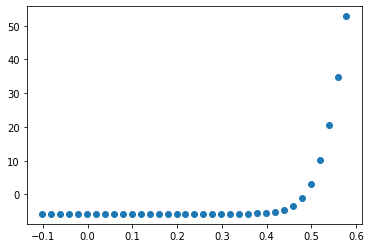

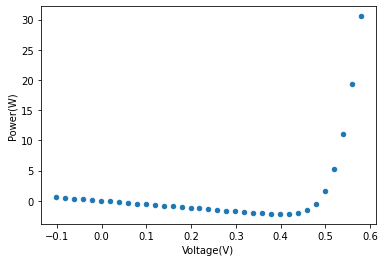

In [ ]:

def get_vals(input_data, spectrum):
  x=[]
  y=[]
  for i in range(35):
    #converts into 1D array by column number
    x.append(float(np.asarray(input_data[list(input_data)[0]][0:35])[i]))
    #changing mA/cm^2 to A/m^2
    y.append(10*float(np.asarray(input_data[list(input_data)[1]][0:35])[i]))
  plt.scatter(x, y)
  #creates spline cubic interpolation function
  f = interp1d(x, y, 'cubic')
  #get zeroes from interpolation 
  Jsc = float(f(0))
  Voc = float(scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots())
  #plot x*y vs x to get P vs V
  PvsVdata = pd.DataFrame(np.stack((np.asarray(x), np.asarray(x)*np.asarray(y)), axis =-1), columns=('Voltage(V)', 'Power(W)'))
  PvsVdata.plot.scatter(x=0, y=1)
  #other relevant quantities
  Pmax = min(PvsVdata['Power(W)'])
  FF = Pmax /(Jsc*Voc)
  #Irradiance from spectral data
  Ispec = (np.asarray(calib_spec[' uJoule/count'])*np.asarray(spectrum[list(spectrum)[0]])).sum()*1e-6/(timems*4.00393e-5)
  PCE = -Pmax / (Ispec*cellarea)
  return 'Data', Ispec, Jsc, Voc, Pmax, FF , PCE
get_vals(AvsVdata, red_spec)

KeyError: ignored

In [ ]:
#constructing other values
spec_data['Spectral Power (W/nm)'] = spec_data['Counts']*spec_data['uJoule/count']*1e-6/timems
spec_data['Spectral Irradiance (W/m^2/nm)'] = spec_data['Spectral Power (W/nm)']/(4.00393e-5)
spec_data

,Wavelength(nm),Counts,uJoule/count,Spectral Power (W/nm),Spectral Irradiance (W/m^2/nm)
0,340.0,-50.730000,-1.292470e-26,6.556699e-30,1.637566e-25
1,341.0,-73.757627,2.488809e-09,-1.835687e-12,-4.584712e-08
2,342.0,-36.996443,-6.477047e-08,2.396277e-11,5.984813e-07
3,343.0,-77.979299,-1.022639e-06,7.974464e-10,1.991659e-05
4,344.0,-46.290978,8.783241e-05,-4.065848e-08,-1.015464e-03
...,...,...,...,...,...
677,1017.0,511.338466,4.476179e-03,2.288842e-05,5.716490e-01
678,1018.0,485.269099,4.630291e-03,2.246937e-05,5.611830e-01
679,1019.0,579.335788,4.737873e-03,2.744820e-05,6.855314e-01
680,1020.0,528.776415,4.762076e-03,2.518074e-05,6.289005e-01


In [ ]:
#Reimann sum - low whether I use WL interval or 1.

rsum = 0
for i in range(682):
  rsum += spec_data['Spectral Irradiance (W/m^2/nm)'][i]
  i += 1
rsum
 

NameError: ignored